In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import sparse

In [2]:
def randfield(nx,ny,cutoff):
    
    # return a smooth, randomly varying field between zero and 1. As cutoff
    # increases, the structure of the field becomes smaller wavelength. 
    f = np.fft.fftshift(np.fft.fft2(np.random.rand(ny,nx)))
    [Nx,Ny] = np.meshgrid(range(0,nx),range(0,ny))
    f[np.sqrt((Nx-nx/2)**2+(Ny-ny/2)**2)>cutoff]=0
    f = np.real(np.fft.ifft2(np.fft.ifftshift(f)))
    f = f-np.amin(f)
    f = f/np.amax(f)
    
    return f

def ind2sub(array_shape, ind):
    rows = (ind / array_shape[1]).astype('int') 
    cols = (ind.astype('int') % array_shape[1]) # or numpy.mod(ind.astype('int'), array_shape[1])
    return (rows, cols)
def sub2ind(array_shape, rows, cols):
    return (rows*array_shape[1] + cols).astype('int')

def propogateouttage(state,edges,k):

    # pixel k is experiencing an outtage. find coordinates of k in the NxN grid
    [i,j] = ind2sub(np.shape(state),k)
    
    # figure out how many "children" each pixel can have
    num_edges = np.size(edges,1)

    # for each edge, if it has a child (edge is non-zero). When non-zero, the edges array stores the k-index of the child
    for e in range(num_edges):
        if edges[k,e]>0:
            
            # check if that child has children and run the outtage code for the child first, recursively 
            state,edges = propogateouttage(state,edges,edges[k,e])
            # set this edge to zero so we know this child is no longer a child anymore
            edges[k,e] = 0

    # set the pixel value here to -1 since it experienced an outtage
    state[i,j] = -1
    return state,edges

def updategrid(s,e,p1,p2,p3,p4):
    
    [Ny,Nx] = np.shape(s)
    neighborsum = np.roll(s,1,axis=0)+np.roll(s,-1,axis=0)+np.roll(s,1,axis=1)+np.roll(s,-1,axis=1)
    for k in np.random.permutation(Ny*Nx):

        [i,j] = ind2sub((Ny,Nx),k)
        sij = s[i,j]
        
        ## if current pixel is OUT
        if sij == -1:
            # restore to decentralization with probability p4
            if np.random.rand() < p4:
                s[i,j] = 0 
                
        ## if current pixel is DECENTRAL
        elif sij == 0:
            # become central with probability n*p2, where n is the number of neighboring central nodes minus the number of neighboring out nodes
            if np.random.rand() < neighborsum[i,j]*p2:
                # set pixel to be central
                s[i,j] = 1 
                # we now need to assign one of the neighboring centralized nodes to be the parent. Lets do this in a random fashion
                for n in np.random.permutation(np.size(e,1)):
                    if n==1:
                        ny = np.mod(i+1,Ny)
                        if s[ny,j]==1:
                            kn = sub2ind((Ny,Nx),ny,j)
                            e[kn,n] = k
                            break # if one of these conditions is set, break, since we only want to set ONE neighbor as the parent
                    elif n==2:
                        nx = np.mod(j-1,Nx)
                        if s[i,nx]==1:
                            kn = sub2ind((Ny,Nx),i,nx)
                            e[kn,n] = k
                            break
                    elif n==3:
                        ny = np.mod(i-1,Ny)
                        if s[ny,j]==1:
                            kn = sub2ind((Ny,Nx),ny,j)
                            e[kn,n] = k
                            break
                    else:
                        nx = np.mod(j+1,Nx)
                        if s[i,nx]==1:
                            kn = sub2ind((Ny,Nx),i,nx)
                            e[kn,n] = k
                            break
            # become central with p1
            elif np.random.rand() < p1:
                s[i,j] = 1
                
        ## if current pixel is CENTRAL
        elif sij == 1:
            # experience an outtage with probability p3
            if np.random.rand() < p3:
                s,e = propogateouttage(s,e,k)
    
    return s,e

In [12]:
## initial conditions
N = 32
state = np.zeros((N,N)) # this field is one if pixel is centralized, and minus one if it experienced an outtage
edges = np.zeros((N*N,4), dtype=int) # keeps track of DIRECTED edges in the network. right now we only inlucde columns (up, left, down, right)

## four probabilities make up the dynamics
p_plant = 0.01; # a pun, both for plant a tree and power plant. This is the probability that a centralized node starts without the need of neighbors, i.e., becomes a power plant
p_join = 0.10; # probability that a de-central node becomes central if its neighbor is central. Compounds linearly with how many neighbors are central
p_outtage = .05; # probability that a centralized nodes undergoes an outtage
p_recover = .25; # probability that an outtage is fixed. this leaves the tile decentral

C:/Users/jtpug/AppData/Local/Temp/xpython_14520/2391078738.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


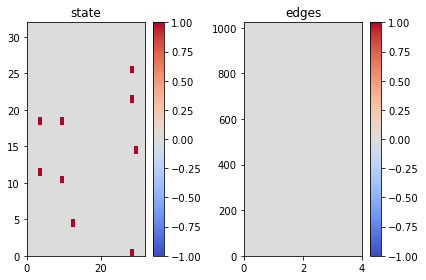

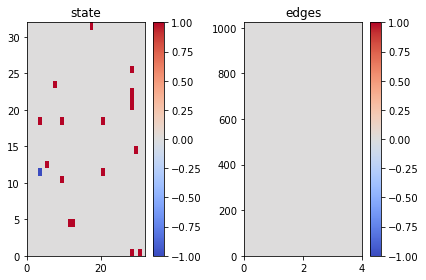

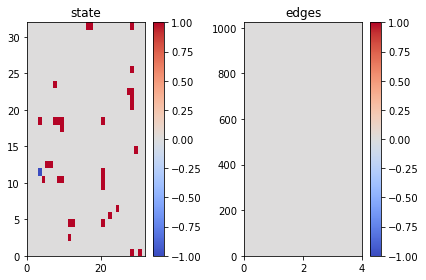

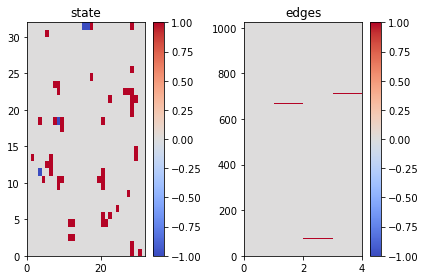

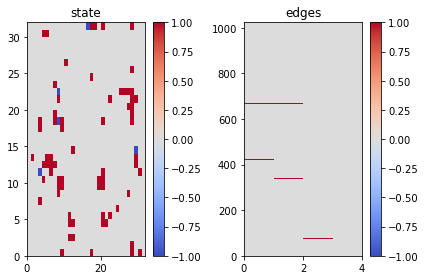

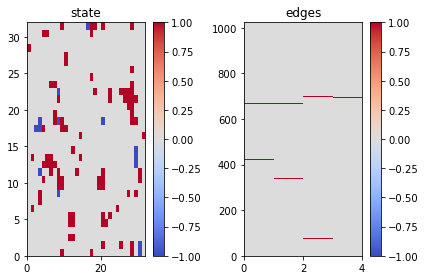

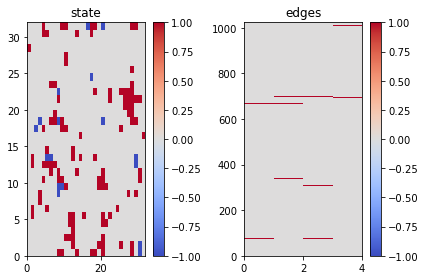

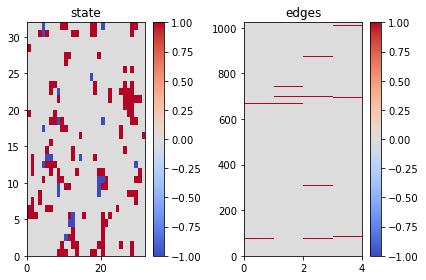

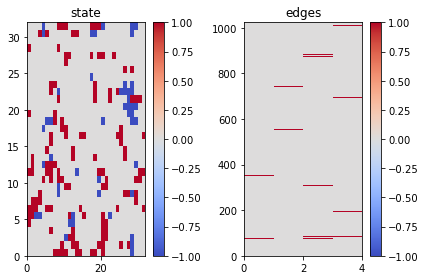

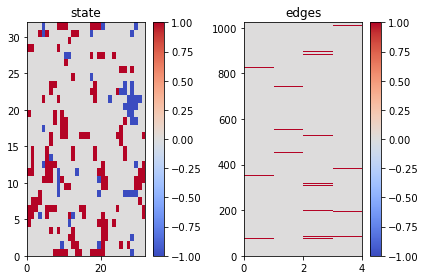

In [13]:

for i in range(10):
    
    state,edges = updategrid(state,edges,p_plant,p_join,p_outtage,p_recover)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    pc = ax1.pcolormesh(state, cmap=cm.coolwarm, vmin = -1, vmax = 1)
    fig.colorbar(pc, ax=ax1)
    ax1.set_title('state')

    pc = ax2.pcolormesh(edges>0, cmap=cm.coolwarm, vmin = -1, vmax = 1)
    fig.colorbar(pc, ax=ax2)
    ax2.set_title('edges')

    # fig, ax = plt.subplots() 
    # im = ax.imshow(state,cmap=cm.coolwarm)
    # color_bar = fig.colorbar(im,norm=matplotlib.colors.Normalize(vmin=-1, vmax=1),extend='both')
    # im.autoscale()
    fig.tight_layout()
    fig.show()
#     im.set_data(state)
#     
#     plt.pause(1)  # In interactive mode, need a small delay to get the plot to appear
#     fig.show()

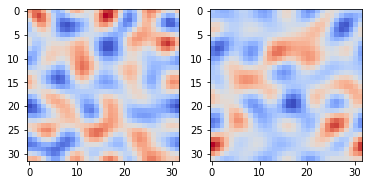

In [15]:
# plot the randomly genderated Demand and PowerGen grids
plt.subplot(121)
plt.imshow(randfield(N,N,5),cmap=cm.coolwarm)
plt.subplot(122)
plt.imshow(randfield(N,N,5),cmap=cm.coolwarm)
plt.show()